In [18]:
!gdown 1p2IO2aBvcQYtdRdHx3QPxhhO3Dl84kdL
!gdown 1xYboSfoDp3wkdHop0acCreWom1uBBHPY

Downloading...
From: https://drive.google.com/uc?id=1p2IO2aBvcQYtdRdHx3QPxhhO3Dl84kdL
To: /content/AI-powered-Sudoku-solver/sudoku_raw.png
100% 16.7k/16.7k [00:00<00:00, 45.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xYboSfoDp3wkdHop0acCreWom1uBBHPY
To: /content/AI-powered-Sudoku-solver/normalblank.jpg
100% 132k/132k [00:00<00:00, 5.08MB/s]


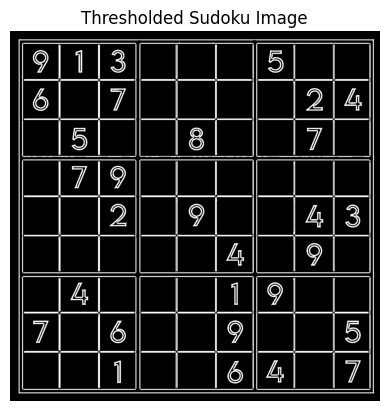

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('/content/normalblank.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur + Adaptive Thresholding
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# Show thresholded image
plt.imshow(thresh, cmap='gray')
plt.title("Thresholded Sudoku Image")
plt.axis('off')
plt.show()


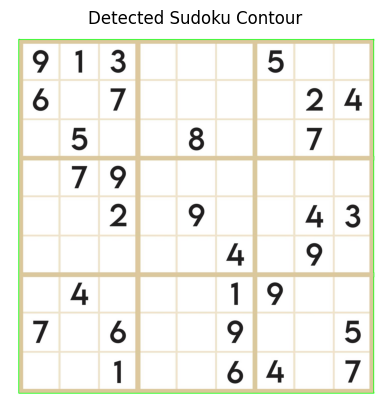

In [20]:
# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find largest contour (assumed to be the grid)
largest_area = 0
sudoku_contour = None
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > largest_area:
        largest_area = area
        sudoku_contour = cnt

# Draw it on a copy of the original
sudoku_outline = image.copy()
cv2.drawContours(sudoku_outline, [sudoku_contour], -1, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(sudoku_outline, cv2.COLOR_BGR2RGB))
plt.title("Detected Sudoku Contour")
plt.axis('off')
plt.show()


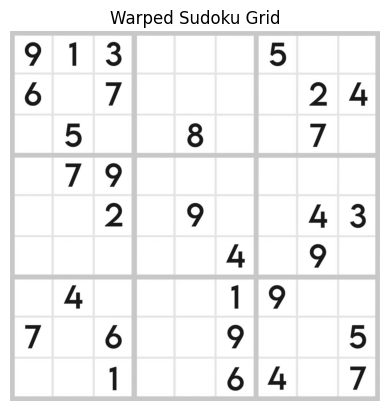

In [21]:
def reorder_points(pts):
    pts = pts.reshape((4, 2))
    new_pts = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    new_pts[0] = pts[np.argmin(s)]      # top-left
    new_pts[2] = pts[np.argmax(s)]      # bottom-right
    new_pts[1] = pts[np.argmin(diff)]   # top-right
    new_pts[3] = pts[np.argmax(diff)]   # bottom-left

    return new_pts

# Approximate the polygon
peri = cv2.arcLength(sudoku_contour, True)
approx = cv2.approxPolyDP(sudoku_contour, 0.02 * peri, True)

if len(approx) == 4:
    pts = reorder_points(approx)
    side = max([
        np.linalg.norm(pts[0] - pts[1]),
        np.linalg.norm(pts[1] - pts[2]),
        np.linalg.norm(pts[2] - pts[3]),
        np.linalg.norm(pts[3] - pts[0])
    ])
    dst_pts = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(pts, dst_pts)
    warped = cv2.warpPerspective(gray, M, (int(side), int(side)))

    plt.imshow(warped, cmap='gray')
    plt.title("Warped Sudoku Grid")
    plt.axis('off')
    plt.show()
else:
    print("Could not detect 4-cornered contour!")
